In [1]:
import pandas as pd
import numpy as np
import pathlib
import datetime
from datetime import datetime, timedelta, date
from rich import print
from collections import namedtuple
from dataclasses import dataclass, asdict
import operator
import tomllib
import tomlkit as tml
import json
import xarray as xr
import csvb.ingest as ci
import plotly.express as px
import plotly.graph_objects as go
from collections import namedtuple
#from decimal import Decimal, getcontext

#getcontext().prec = 2
pd.options.mode.copy_on_write = True

In [2]:
Transaction = namedtuple("Transaction", ["Date", "Amount", "From", "To", "Description", "Notes"], defaults=[""])

In [3]:
HOME = pathlib.Path.home()
cfgpth = HOME / ".config" / "csvb" / "config.toml"
with open(cfgpth, 'rb') as f:
    cfg = tomllib.load(f)
RULESPTH = HOME / cfg["paths"]["rules"]
BANKPTH = HOME / cfg["paths"]["bank"]
PRODUCTSPTH = HOME / cfg["paths"]["products"]
ACCT_NAMES = ["Type", "Account", "Subaccount"]
INST_ACCOUNTS = ["Assets:1st Source:Checking",
                 "Assets:Fidelity:HSA",
                 "Assets:Ally:Savins",
                 "Liabilities:NDFCU:Credit Card",
                 "Liabilities:Apple:Credit Card",
                 "Liabilities:Apple:Installments"]

In [4]:
fd  = ci.find_bank_files(HOME / pathlib.Path(cfg["paths"]["bank"])) 

In [5]:
try:
    del apl
except NameError:
    pass
apl = ci.ingest_bank_files(fd["Liabilities:Apple:Credit Card"]["files"],
                           fd["Liabilities:Apple:Credit Card"],
                           RULESPTH)

apl = ci.read_and_apply(apl, RULESPTH / fd["Liabilities:Apple:Credit Card"]["rules_file"])
apl[apl["From"] == ""]

Empty DataFrame
Columns: [Transaction Date, Clearing Date, Description, Merchant, Category, Type, Amount (USD), Purchased By, Amount, From]
Index: []

In [6]:
try:
    del apl_inc
except NameError:
    pass
apl_inc = ci.ingest_bank_files(fd["Liabilities:Apple:Installments"]["files"],
                           fd["Liabilities:Apple:Installments"],
                           RULESPTH)

apl_inc[apl_inc["From"] == ""]

Empty DataFrame
Columns: [Date, Description, Amount, From]
Index: []

In [7]:
try:
    del fst
except NameError:
    pass
fst = ci.ingest_bank_files(fd["Assets:1st Source:Checking"]["files"],
                           fd["Assets:1st Source:Checking"],
                           RULESPTH)

fst = ci.read_and_apply(fst, RULESPTH / fd["Assets:1st Source:Checking"]["rules_file"])

fst[fst["From"] == ""]
#fst["Date"].max()

Empty DataFrame
Columns: [Transaction Number, Date, Description, Memo, Amount Debit, Amount Credit, Balance, Amount, From, Check Number, Fees  ]
Index: []

In [8]:
try:
    del ally
except NameError:
    pass
ally = ci.ingest_bank_files(fd["Assets:Ally:Savings"]["files"],
                           fd["Assets:Ally:Savings"],
                           RULESPTH)

ally = ci.read_and_apply(ally, RULESPTH / fd["Assets:Ally:Savings"]["rules_file"])

ally[ally["From"] == ""]
#ally.sort_values("Date")
#fd["Assets:Ally:Savings"]

Empty DataFrame
Columns: [Date, Time, Amount, Type, Description, From]
Index: []

In [9]:
try:
    del ndfcu
except NameError:
    pass
ndfcu = ci.ingest_bank_files(fd["Liabilities:NDFCU:Credit Card"]["files"],
                           fd["Liabilities:NDFCU:Credit Card"],
                           RULESPTH)

ndfcu = ci.read_and_apply(ndfcu, RULESPTH / fd["Liabilities:NDFCU:Credit Card"]["rules_file"])

ndfcu["Description"] = ndfcu["Description"].fillna("")

ndfcu[ndfcu["From"] == ""]
ndfcu[pd.isnull(ndfcu["From"])]

Empty DataFrame
Columns: [Date, Note, Description, Amount, Balance, From]
Index: []

In [10]:
try:
    del hsa
except NameError:
    pass
hsa = ci.ingest_bank_files(fd["Assets:Fidelity:HSA"]["files"],
                           fd["Assets:Fidelity:HSA"],
                           RULESPTH)
hsa = hsa.rename(columns={"Run Date": "Date",
                          "Action": "Description",
                          "Description": "Note",
                          "Amount ($)": "Amount",
                          
                         }
                )

hsa = ci.read_and_apply(hsa, RULESPTH / fd["Assets:Fidelity:HSA"]["rules_file"])
#hsa[pd.isnull(hsa["From"])]

In [11]:
bank_tables = {"Assets:1st Source:Checking": fst,
               "Liabilities:Apple:Credit Card": apl.rename(columns={"Transaction Date": "Date"}),
              "Assets:Ally:Savings": ally,
              "Liabilities:NDFCU:Credit Card": ndfcu,
              "Liabilities:Apple:Installments": apl_inc,
              "Assets:Fidelity:HSA": hsa}


trans = ci.to_transactions(bank_tables)
trans = trans.sort_values("Date")

In [12]:
try:
    del bal_decl
except NameError:
    pass

bal_decl = pd.read_csv(HOME / pathlib.Path(cfg["paths"]["bank"]) / "balances.csv",
                  header=0,
                  parse_dates=["Date"])


In [13]:
trans = pd.concat([trans, ci.gen_init_balance_trans(bal_decl)], ignore_index=True).sort_values("Date")
#trans[trans["To"] == "Assets:Fidelity:HSA"]

In [14]:
try:
    del ledgers
except NameError:
    pass
    
#ledgers = create_ledgers(trans)
#ledgers = ci.trans_to_ledgers(trans, bal_decl=bal_decl)
#ledgers[ledgers["Account"] == "Assets:1st Source:Checking"]
#ledgers[ledgers["Transaction Pair"] == "Liabilities:Auto:Loan"]
fg = trans.groupby("From")
tg = trans.groupby("To")
fl = {}
for acct in fg.groups:
    fl[acct] = trans.loc[fg.groups[acct]][["Date", "Description", "To"]].rename(columns={"To": "Transaction Pair"})
                                                                                                       
    fl[acct]["Incoming Amount"] = - 1 * trans.loc[fg.groups[acct]]["Amount"]
    fl[acct]["Account String"] = [acct] * len(fl[acct])

tl = {}
for acct in tg.groups:
    tl[acct] = trans.loc[tg.groups[acct]][["Date", "Description", "From"]].rename(columns={"From": "Transaction Pair"})
                                                                                                       
    tl[acct]["Incoming Amount"] = trans.loc[tg.groups[acct]]["Amount"]
    tl[acct]["Account String"] = [acct] * len(tl[acct])

ledgers = pd.concat(list(tl.values()) + list(fl.values())).sort_values("Date", ignore_index=True)

# Split account string to tuples.
acct_tuples = ledgers["Account String"].apply(lambda t:ci.to_triple(t, fill="")).apply(pd.Series).rename(columns=dict(zip(range(3), ACCT_NAMES)))
ledgers = pd.concat([ledgers, acct_tuples], axis="columns")

# Calculate cumulative balance.
ledgers["Balance"] = ledgers.groupby("Account String")["Incoming Amount"].cumsum()

#ledgers


# Ledger Table with Zeros

In [15]:
lw0 = ledgers
#lw0 = lw0.set_index("Date")
daily = pd.date_range(start=lw0["Date"].min(), end=lw0["Date"].max(), freq="1D")
def add_dates(df):
    datesnotin = daily[~daily.isin(df["Date"])]
    newdf = pd.DataFrame({"Date": datesnotin,
                          "Incoming Amount": [0.0] * len(datesnotin),
                          "Description": ["Fake Zero"] * len(datesnotin)
                         })
    newdf = pd.concat([df, newdf]).sort_values("Date")
    #print(newdf)
    cols=["Transaction Pair", "Account String", "Balance"]
    newdf.loc[:, cols]  = newdf.loc[:, cols].ffill()
    newdf.loc[:, ["Transaction Pair", "Account String"]] = newdf.loc[:, ["Transaction Pair", "Account String"]].bfill()
    #print(newdf)
    newdf["Balance"] = newdf["Balance"].fillna(0.0)
    return newdf
    
lw0 = lw0.groupby(ACCT_NAMES).apply(add_dates, include_groups=False)
lw0=lw0.reset_index().drop(columns="level_3").sort_values("Date")

In [16]:
#g = ledge_with_acct["Incoming Amount"].groupby(ledge_with_acct.index).sum("Incoming Amount")
# Select all lines with an initial balance.

clear_virtuals=True

start_date = None
end_date = None #date(2024,1,1)

ltable = ledgers

if start_date is not None:
    ltable = ltable[ltable["Date"] >= pd.Timestamp(start_date)]
if end_date is not None:
    ltable = ltable[ltable["Date"] <= pd.Timestamp(end_date)]


# Group on Accounts
acct_g = ltable.groupby(ACCT_NAMES)

# Choose first and last date of each group from ltable, reassign with column names and set account as multiindex.
start = acct_g.head(1)[["Date", "Balance"] + ACCT_NAMES].rename(columns={"Date": "Start Date", "Balance": "Initial Balance"}).set_index(ACCT_NAMES)
end = acct_g.tail(1)[["Date", "Balance"] + ACCT_NAMES].rename(columns={"Date": "End Date", "Balance": "End Balance"}).set_index(ACCT_NAMES)

#br = br.set_index(pd.MultiIndex.from_tuples(br.index.to_series().apply(ci.to_triple), names=["Type", "Account", "Subaccount"])a
br = pd.concat([start, end],axis="columns")
br["Difference"] = br["End Balance"] - br["Initial Balance"]
br
#acct_g["Date"].groups["Expenses:Reimbursible"]

Start Date  Initial Balance  \
Type        Account         Subaccount                                     
Assets      1st Source      Checking         2021-12-31          5067.54   
Liabilities Apple           Credit Card      2021-12-31           -11.04   
                            Installments     2021-12-31          -738.94   
            NDFCU           Credit Card      2021-12-31           -26.93   
Equity      Initial Balance                  2021-12-31          2522.77   
...                                                 ...              ...   
Income      Notre Dame      HSA Contribution 2023-02-02          -279.16   
Expenses    Medical         Dentist          2023-05-26           114.00   
            Auto            Gas              2023-06-13             7.08   
            Services                         2024-03-10            59.95   
            Recovery                         2024-03-13           255.94   

                                               End Date  End Balance  \
Type        Account         Subaccount                                 
Assets      1st Source      Checking         2024-05-31     13498.21   
Liabilities Apple           Credit Card      2024-05-31     -4901.43   
                            Installments     2024-05-31     -1699.66   
            NDFCU           Credit Card      2024-05-29       246.82   
Equity      Initial Balance                  2022-12-31     -5541.11   
...                                                 ...          ...   
Income      Notre Dame      HSA Contribution 2024-06-04     -5745.72   
Expenses    Medical         Dentist          2023-05-26       114.00   
            Auto            Gas              2024-04-26        80.17   
            Services                         2024-03-10        59.95   
            Recovery                         2024-03-13       255.94   

                                              Difference  
Type        Account         Subaccount                    
Assets      1st Source      Checking             8430.67  
Liabilities Apple           Credit Card         -4890.39  
                            Installments         -960.72  
            NDFCU           Credit Card           273.75  
Equity      Initial Balance                     -8063.88  
...                                                  ...  
Income      Notre Dame      HSA Contribution    -5466.56  
Expenses    Medical         Dentist                 0.00  
            Auto            Gas                    73.09  
            Services                                0.00  
            Recovery                                0.00  

[65 rows x 5 columns]

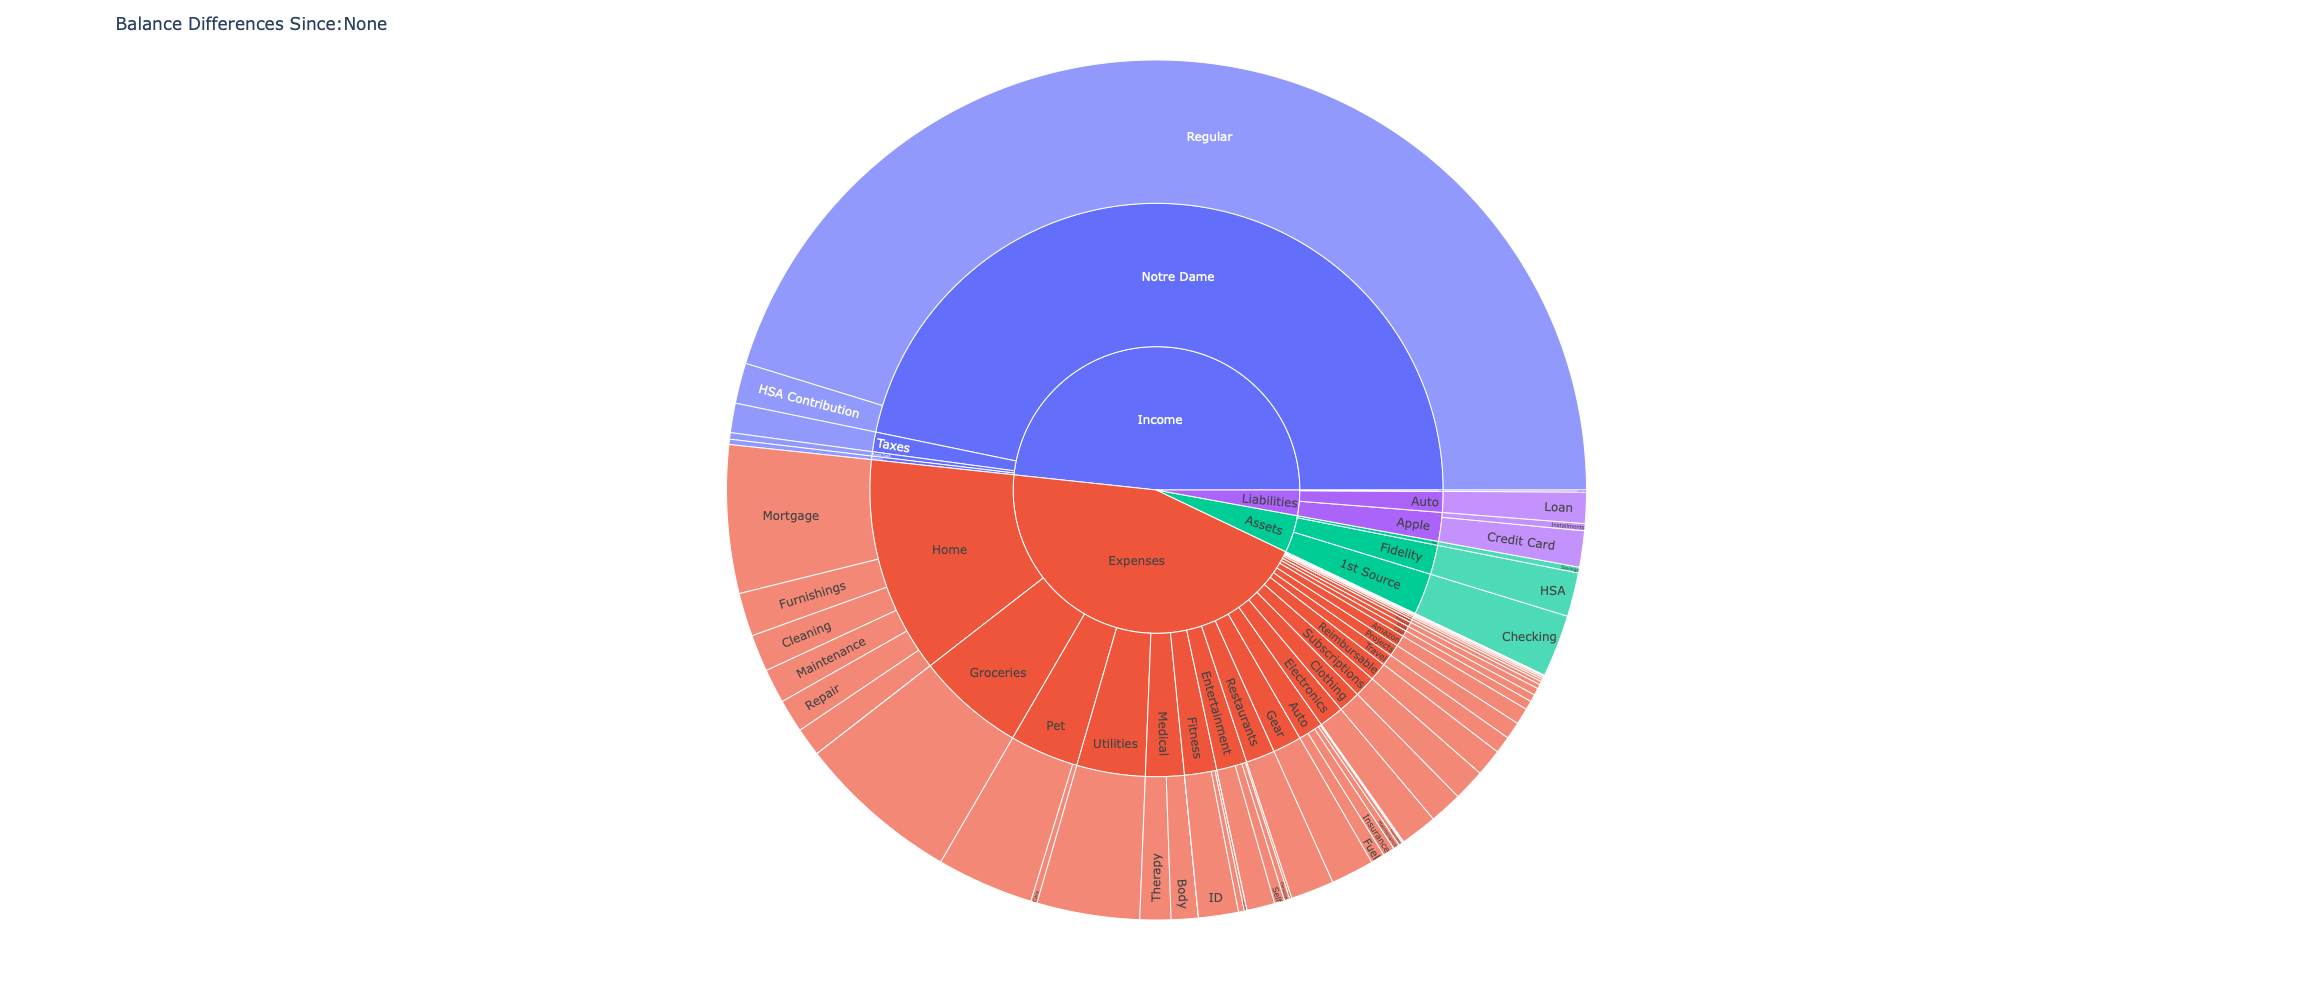

In [17]:
#cutoff_ledgers["Liabilities:Auto:Loan"].iloc[-2:-1]
#cb = ci.balances(ledgers)
#cb
df = br
df = pd.DataFrame({"Type": df.index.get_level_values("Type"),
                   "Account": df.index.get_level_values("Account"),
                   "Subaccount": df.index.get_level_values("Subaccount"),
                   "Difference": df["Difference"].apply(np.abs)})
df = df.loc[df["Type"] != "Transfer"]
df = df.loc[df["Type"] != "Equity"]
df = df.fillna("")
df = df.replace(np.inf,0)
#df = df.loc[
sbfig = px.sunburst(df, path=["Type", "Account", "Subaccount"], values="Difference")
sbfig.update_layout(height=1000, title=f"Balance Differences Since:{str(start_date)}")
sbfig.show()
#sbfig.data

In [18]:
#flow = trans.groupby(["From", "To"])
pt = trans.copy()
pt.loc[trans["Amount"] < 0, "To"] = trans.loc[trans["Amount"] < 0, "From"]
pt.loc[trans["Amount"] < 0, "From"] = trans.loc[trans["Amount"] < 0, "To"]
pt.loc[trans["Amount"] < 0, "Amount"] = -1 * trans.loc[trans["Amount"] < 0, "Amount"]
flow = pt.groupby(["From", "To"])
flow_df = pd.DataFrame(flow.Amount.aggregate("sum"))

In [19]:
accts = list(ci.accounts(flow_df.index.to_frame()))

labels = accts
sources = [accts.index(a) for a in flow_df.index.to_frame()["From"].values]
targets = [accts.index(a) for a in flow_df.index.to_frame()["To"].values]
values = flow_df["Amount"]

f = go.Figure(data=[go.Sankey(
    node = dict(
        pad=15,
        thickness = 5,
        line=dict(color = "black", width = 0.5),
        label = labels
    ),
    link = dict(
        source = sources,
        target = targets,
        value = values.values,
    )
)
                   ]
             )


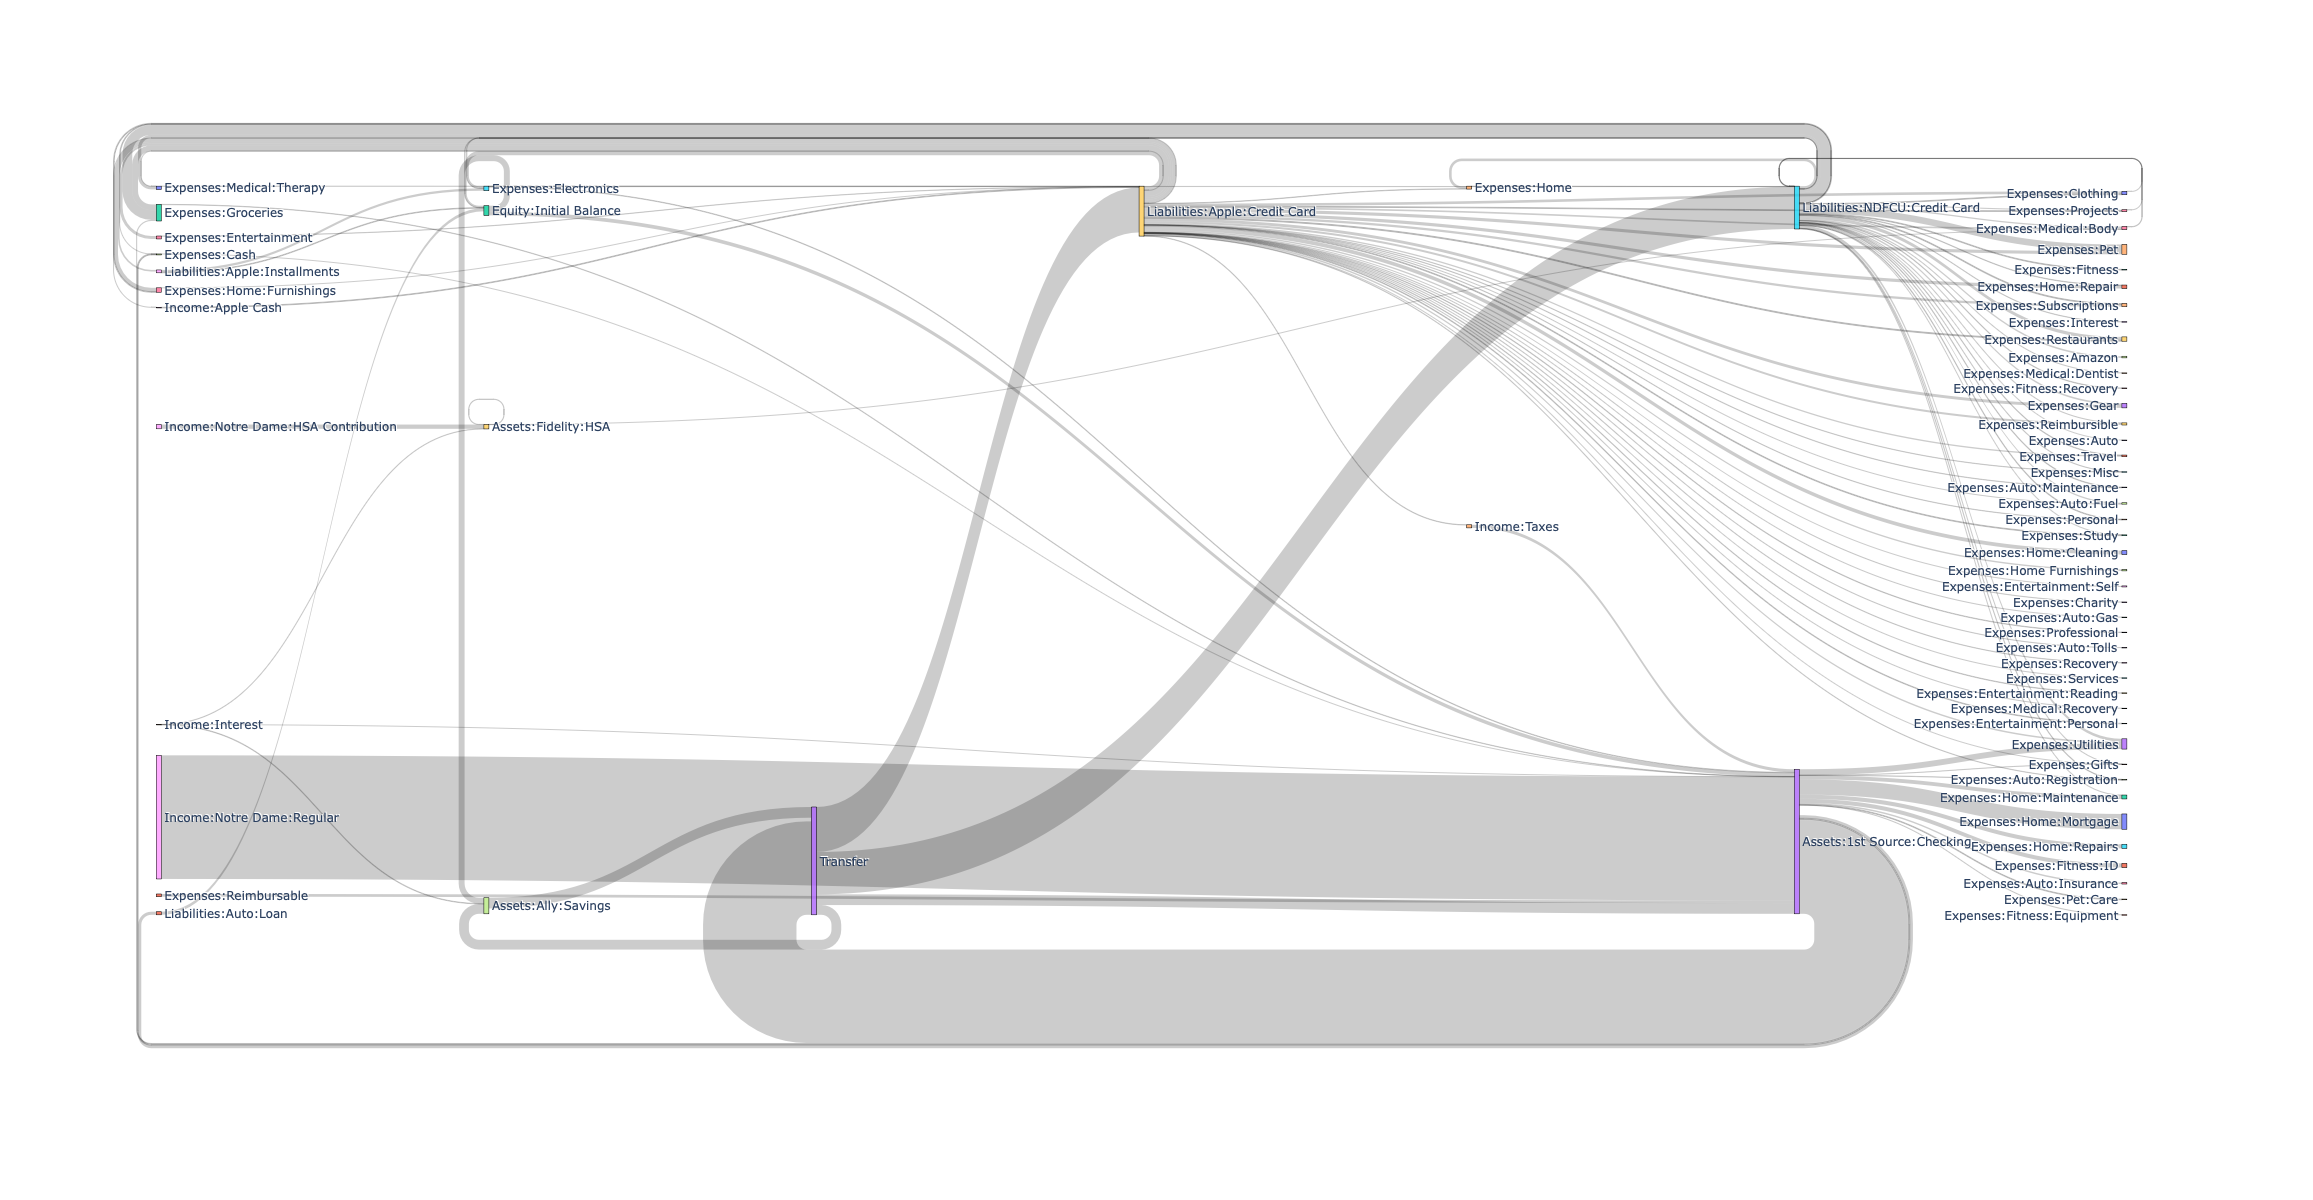

In [20]:
f.update_layout(height=1200)
f.show()

In [21]:
monthly_sum = lw0.groupby(ACCT_NAMES + ["Date"]).sum().groupby(ACCT_NAMES + [pd.Grouper(freq="ME", level=-1)])["Incoming Amount"].sum()
px.scatter(monthly_sum.loc[("Expenses", "Electronics", "")], y="Incoming Amount")

monthly_mean = monthly_sum.groupby(ACCT_NAMES).mean()

In [22]:
monthly_mean

Type         Account          Subaccount  
Assets       1st Source       Checking        4.354261e+02
             Ally             Savings         2.337010e+02
             Fidelity         HSA             1.915126e+02
Equity       Initial Balance                 -1.787455e+02
Expenses     Amazon                           7.184065e+01
                                                  ...     
Liabilities  Apple            Credit Card    -1.581106e+02
                              Installments   -5.482774e+01
             Auto             Loan           -3.667317e-15
             NDFCU            Credit Card     7.961935e+00
Transfer                                     -1.612903e+02
Name: Incoming Amount, Length: 65, dtype: float64

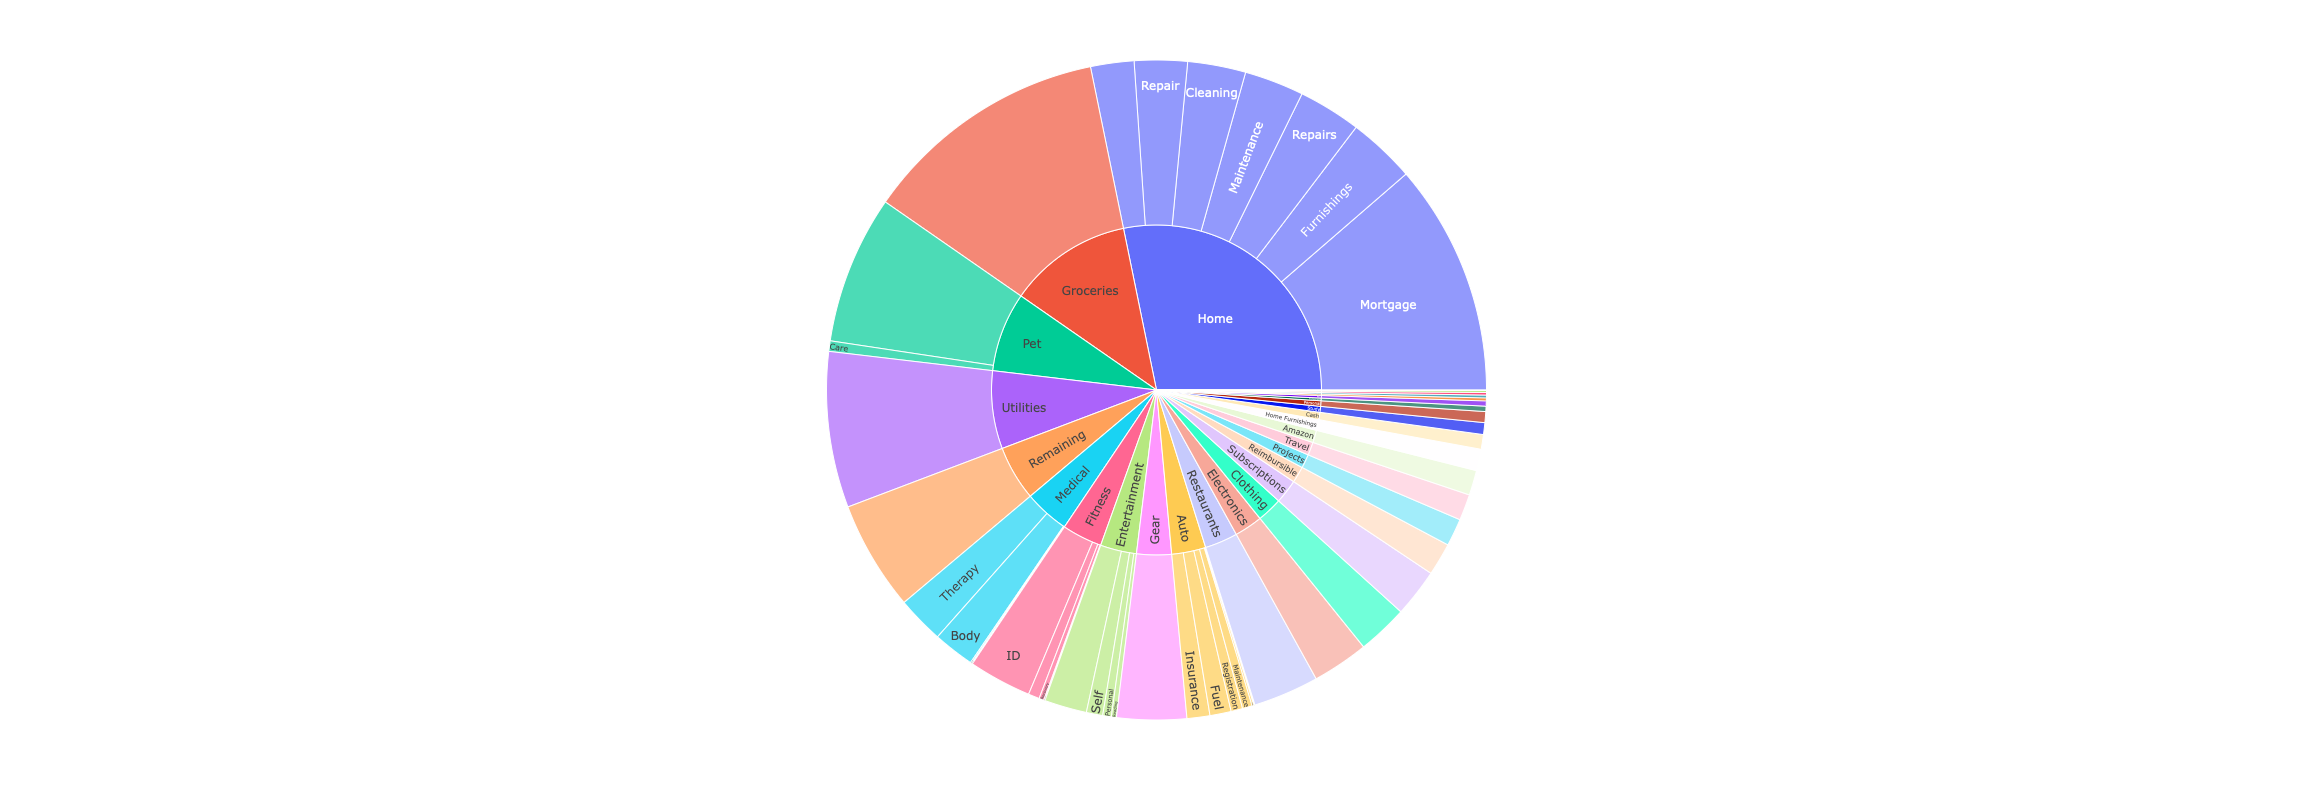

In [23]:
mean_expenses = monthly_mean["Expenses"]
remaining = mean_expenses.sum() + monthly_mean["Income"].sum()
monthly = pd.concat([mean_expenses, pd.Series(data=-1 * remaining, index=pd.MultiIndex.from_tuples([("Remaining", "", "")]))], axis="rows")
monthly.index.names=["Account", "Subaccount"]
monthly.name="Total"
px.sunburst(monthly.reset_index(), path=["Account", "Subaccount"], values="Total", height =800)

In [24]:
trans[trans.From == "Expenses:Utilities"]

Date                                        Description  Amount  \
16   2022-01-05  AMZN MKTP US*ET0DT6QC3   . AMZN.COM/BILL. WA 0000  -17.12   
25   2022-01-12                          VERIZON WIRELESS PAYMENTS -107.88   
29   2022-01-14  CITY OF SOUTH BEND       . 574-223-0311 . IN 0000  -88.80   
31   2022-01-14                          AEP INDIANA MICH BILL PAY -101.15   
38   2022-01-16  AMZN MKTP US*HU2BX13K3   . AMZN.COM/BILL. WA 0000  -85.96   
...         ...                                                ...     ...   
2603 2024-05-06                          AEP INDIANA MICH BILL PAY  -94.21   
2607 2024-05-07  GANNETT NEWSPRPR OH 13095 PUBLISHERS DRIVE 888...   -9.99   
2614 2024-05-08                            NIPSCO ACCOUNTS BILLPAY  -45.65   
2619 2024-05-09                          VERIZON WIRELESS PAYMENTS -114.59   
2639 2024-05-19  COMCAST CHICAGO          . 800-COMCAST  . IL 0000 -107.05   

                    From                             To  
16    Expenses:Utilities  Liabilities:NDFCU:Credit Card  
25    Expenses:Utilities     Assets:1st Source:Checking  
29    Expenses:Utilities  Liabilities:NDFCU:Credit Card  
31    Expenses:Utilities     Assets:1st Source:Checking  
38    Expenses:Utilities  Liabilities:NDFCU:Credit Card  
...                  ...                            ...  
2603  Expenses:Utilities     Assets:1st Source:Checking  
2607  Expenses:Utilities  Liabilities:Apple:Credit Card  
2614  Expenses:Utilities     Assets:1st Source:Checking  
2619  Expenses:Utilities     Assets:1st Source:Checking  
2639  Expenses:Utilities  Liabilities:NDFCU:Credit Card  

[173 rows x 5 columns]

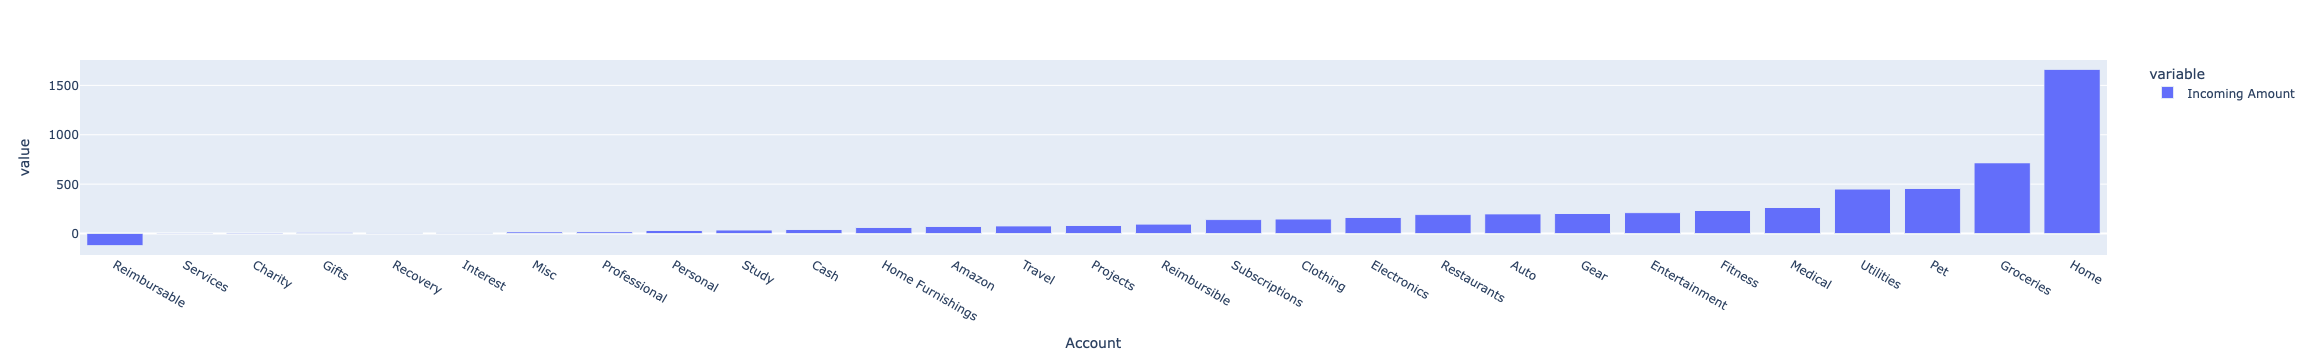

In [25]:
df = monthly_mean["Expenses"].groupby(["Account"]).sum().sort_values()
px.bar(df)

In [26]:
pmsum = monthly_sum["Expenses"]#.reset_index()
#pmsum["Acctstr"] = pmsum["Account"] + ":" + pmsum["Subaccount"]
#pmsum["Date"] = pmsum["Date"].astype(object).apply(pd.Period.to_timestamp)

In [27]:
pmsum=pmsum.reorder_levels(["Date", "Account", "Subaccount"])

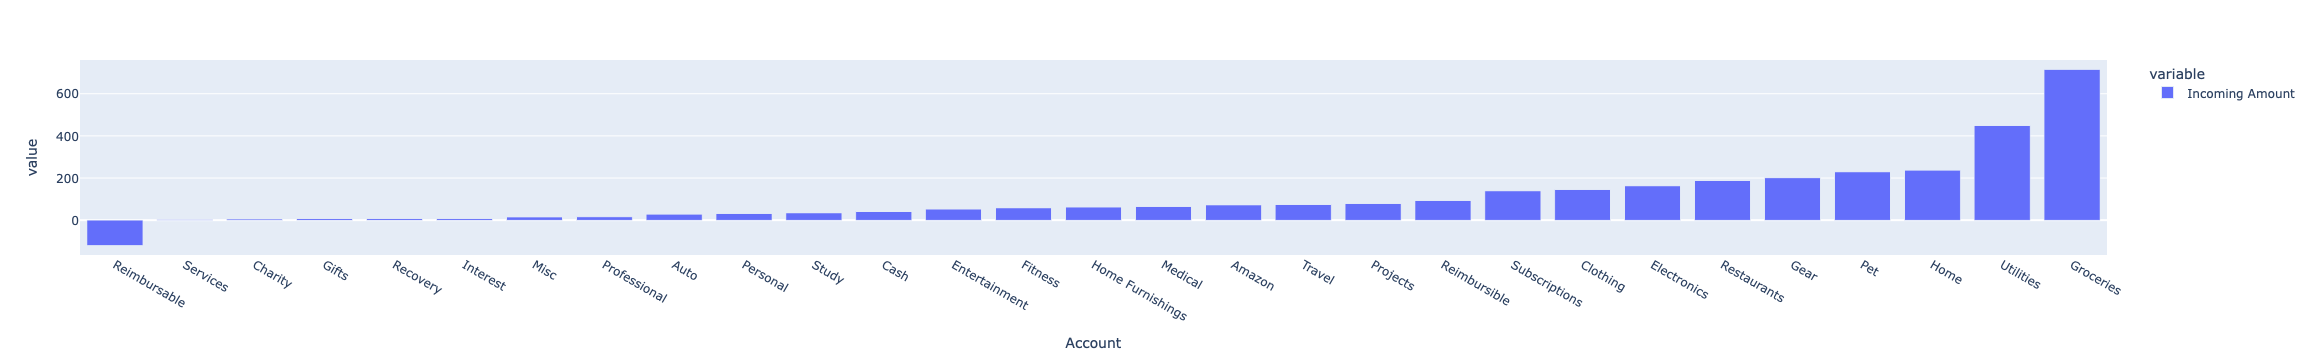

In [28]:
df = monthly_sum["Expenses"]
#px.bar(df.sort_values())
df = df.groupby("Account").mean()
px.bar(df.sort_values())

In [29]:
pdextension = pd.period_range(start = pmsum.index.levels[0][-1], end=pd.Period("2024-12"), freq="M")[1:]

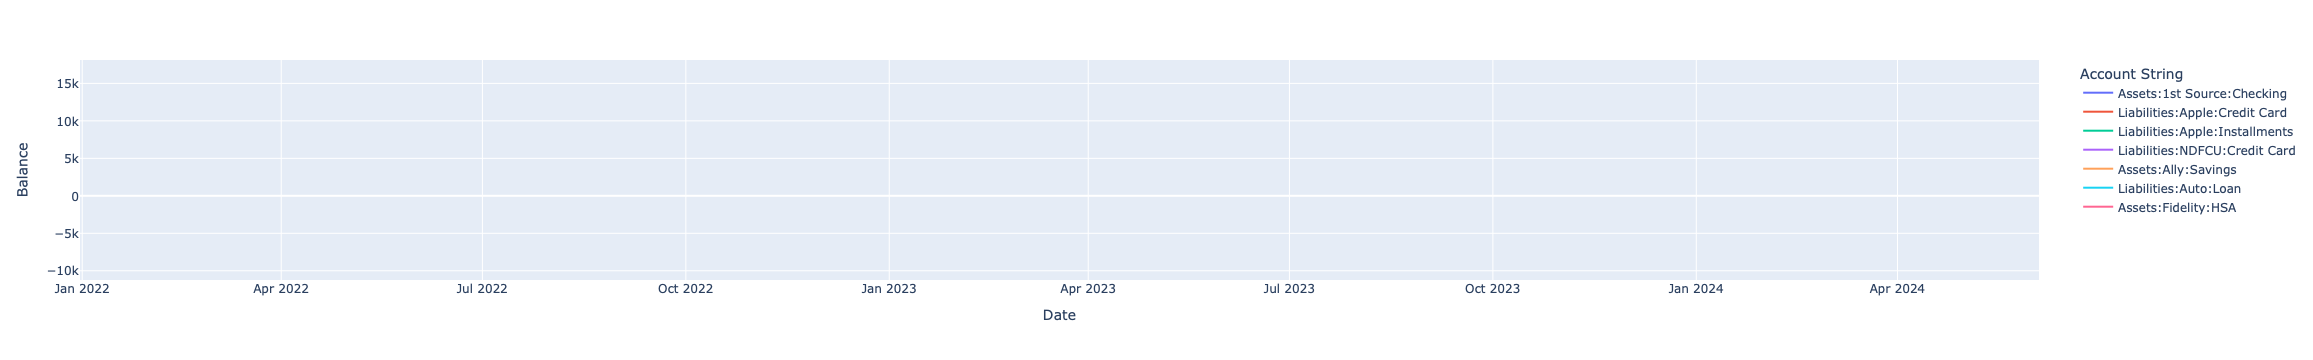

In [30]:
px.line(ledgers[ledgers["Type"].isin(["Assets", "Liabilities"])], x="Date", y="Balance", color="Account String")

In [31]:
budget = {}
for idx in pdextension:
    budget[idx] = monthly_mean
budget = pd.DataFrame(budget)

In [32]:
btrans = pd.DataFrame(budget.T.stack(["Account", "Subaccount"])).rename(columns={0:"Amount"})
#help(btrans.index)
#btrans["Account String"] = [":".join(("Expenses", a, b)) for a, b in zip(btrans.index.get_level_values("Account"),
#                                                           btrans.index.get_level_values("Subaccount"))]
#btrans=btrans.droplevel("Account")
#btrans=btrans.droplevel("Subaccount")

#def stripcolon(s):
#    if s.endswith(":"):
#        return s[:-1]
#    else:
#        return s
#btrans["To"] = btrans["Account String"].apply(stripcolon)

/var/folders/42/qqsltqsj6fl30wl4xm41gs4m0000gn/T/ipykernel_69573/1351139105.py:1: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.



In [33]:
endassets = br.loc["Assets"]["End Balance"]
endliabilities = br.loc["Liabilities"]["End Balance"]

In [34]:
start = pd.DataFrame(pd.concat([endassets, endliabilities])).rename(columns={"End Balance": "Balance"})

In [35]:
start["Description"] = "Ending Balance"

In [36]:
expsum = btrans.groupby(level=0).sum()
#expsum["Balance"] = expsum.cumsum()

In [37]:
expsum

Type         Assets      Equity     Expenses       Income  Liabilities  \
2024-07  860.639677 -178.745484  5443.889355 -5759.516774  -204.976452   
2024-08  860.639677 -178.745484  5443.889355 -5759.516774  -204.976452   
2024-09  860.639677 -178.745484  5443.889355 -5759.516774  -204.976452   
2024-10  860.639677 -178.745484  5443.889355 -5759.516774  -204.976452   
2024-11  860.639677 -178.745484  5443.889355 -5759.516774  -204.976452   
2024-12  860.639677 -178.745484  5443.889355 -5759.516774  -204.976452   

Type       Transfer  
2024-07 -161.290323  
2024-08 -161.290323  
2024-09 -161.290323  
2024-10 -161.290323  
2024-11 -161.290323  
2024-12 -161.290323

In [38]:
dfs = {}
keep = ["Date", "Description", "Account String"]
accts = []
for typ in ["Assets", "Liabilities", "Transfer"]:
    accts.append(pd.unique(ledgers[ledgers["Type"] == typ]["Account String"]))
accts = np.concatenate(accts)

bals = []
grouped = ledgers.groupby("Account String")
for acct in accts:
    bals.append(grouped.get_group(acct)["Balance"].rename("Balance " + acct))

balance_table=pd.concat([ledgers[keep], pd.concat(bals, axis="columns")], join="inner", axis="columns").sort_values("Date").ffill().fillna(0)

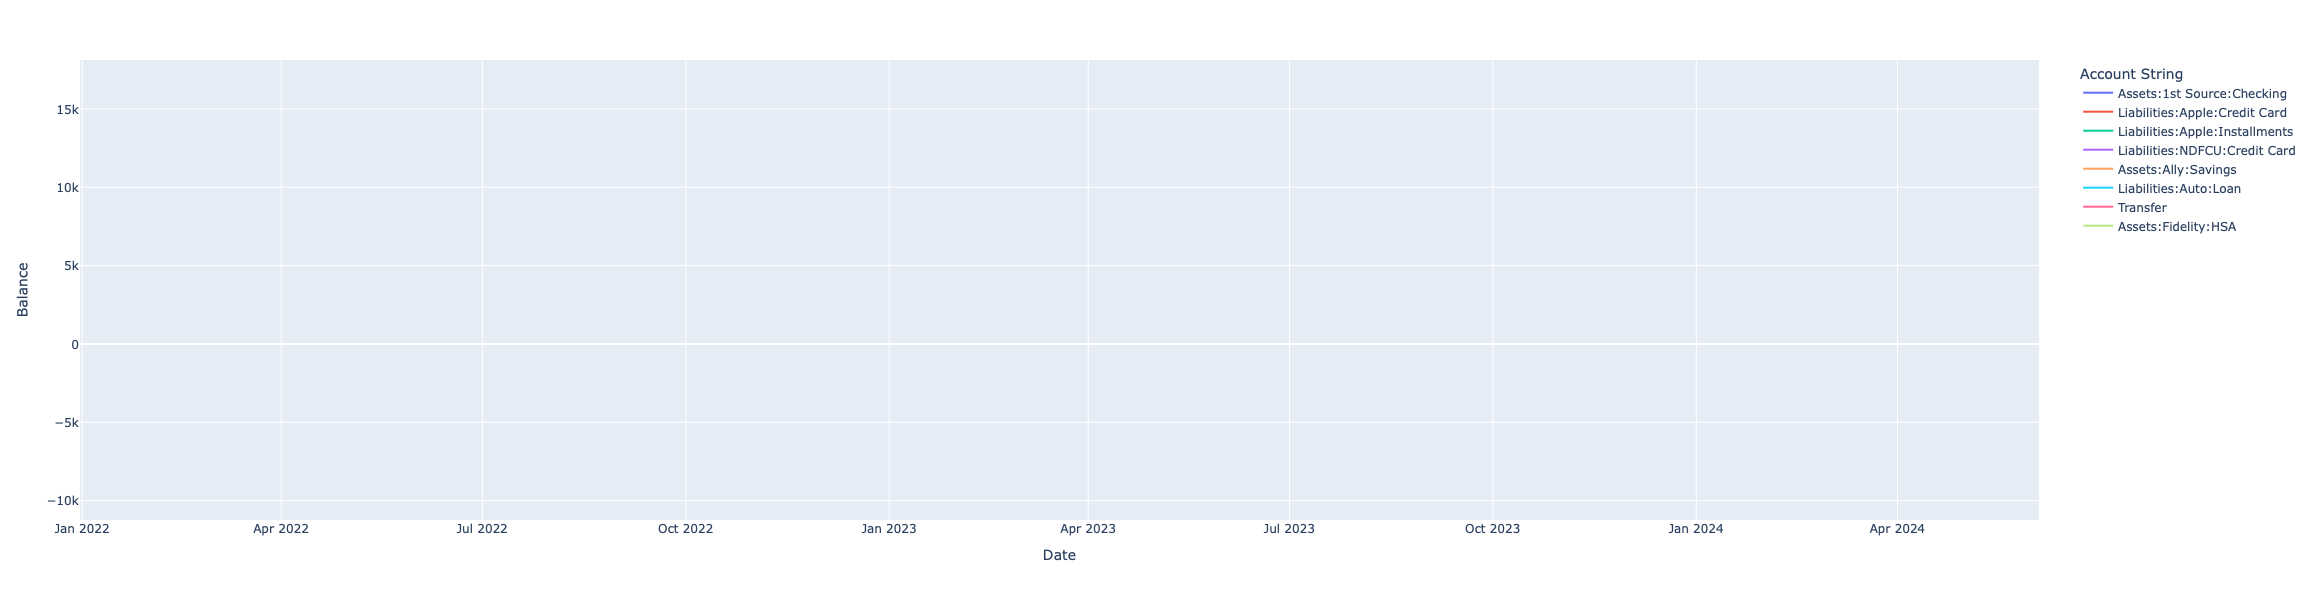

In [39]:
px.line(ledgers[ledgers["Type"].isin(["Assets", "Liabilities", "Transfer"])].set_index("Date"),
        y="Balance", color="Account String", height=600)

In [40]:
pd.set_option('display.max_rows', 100, 'display.max_columns', None)

In [41]:
asgrouped = ledgers.groupby("Account String")["Incoming Amount"].sum()
asgrouped.name="Asset String"
tpgrouped = ledgers.groupby("Transaction Pair")["Incoming Amount"].sum()
tpgrouped.name="Transaction Pair"

In [42]:
pd.options.display.float_format = '{:,.2f}'.format


check = pd.concat([asgrouped,-1 *  tpgrouped], axis="columns")#.rename(columns={"Incoming Amount"Asset String", 1:"Transaction Pair"})

In [43]:
check[check["Asset String"] != check["Transaction Pair"]].assign(Diff=check["Asset String"] - check["Transaction Pair"])

Asset String  Transaction Pair  Diff
Liabilities:Apple:Credit Card     -4,901.43         -4,901.43  0.00
Liabilities:NDFCU:Credit Card        246.82            246.82 -0.00

In [44]:
final_balance = ledgers.groupby(ACCT_NAMES)["Incoming Amount"].sum()

In [45]:
monthly_incoming = lw0.set_index(["Date"]).sort_index().groupby(ACCT_NAMES).resample("ME")["Incoming Amount"].sum()

In [46]:
this_year_inc = monthly_incoming.loc[(slice(None), slice(None), slice(None), slice(pd.Timestamp("2023-12-31"), pd.Timestamp("2024-05-31")))]

In [95]:
end_of_2023_bals = lw0.set_index(["Date"]).sort_index()[:pd.Timestamp("2023-12-31")].groupby(ACCT_NAMES)["Incoming Amount"].sum()

In [96]:
meaningful_eo23_bals = end_of_2023_bals.loc[["Assets", "Liabilities", "Transfer"]]

In [97]:
meaningful_eo23_bals

Type         Account     Subaccount  
Assets       1st Source  Checking        2,320.49
             Ally        Savings        10,058.08
             Fidelity    HSA             3,939.33
Liabilities  Apple       Credit Card       129.35
                         Installments     -850.78
             Auto        Loan               -0.00
             NDFCU       Credit Card     1,431.08
Transfer                                     0.00
Name: Incoming Amount, dtype: float64

In [98]:
budget.loc[["Income"]]

2024-07   2024-08   2024-09   2024-10  \
Type   Account    Subaccount                                                 
Income Apple Cash                     -29.14    -29.14    -29.14    -29.14   
       Interest                       -23.23    -23.23    -23.23    -23.23   
       Notre Dame HSA Contribution   -185.35   -185.35   -185.35   -185.35   
                  Regular          -5,396.93 -5,396.93 -5,396.93 -5,396.93   
       Taxes                         -124.87   -124.87   -124.87   -124.87   

                                     2024-11   2024-12  
Type   Account    Subaccount                            
Income Apple Cash                     -29.14    -29.14  
       Interest                       -23.23    -23.23  
       Notre Dame HSA Contribution   -185.35   -185.35  
                  Regular          -5,396.93 -5,396.93  
       Taxes                         -124.87   -124.87

In [99]:
tot_exp_2024_to_date=this_year_inc["Expenses"].sum()
print(tot_exp_2024_to_date)

38118.08

In [100]:
tot_inc_2024_to_date=this_year_inc["Income"].sum()
print(-1*tot_inc_2024_to_date)

35639.509999999995

In [101]:
-1 * tot_inc_2024_to_date - tot_exp_2024_to_date

-2478.570000000007

In [102]:
meaningful_eo23_bals

Type         Account     Subaccount  
Assets       1st Source  Checking        2,320.49
             Ally        Savings        10,058.08
             Fidelity    HSA             3,939.33
Liabilities  Apple       Credit Card       129.35
                         Installments     -850.78
             Auto        Loan               -0.00
             NDFCU       Credit Card     1,431.08
Transfer                                     0.00
Name: Incoming Amount, dtype: float64

In [104]:
final_balance.loc[["Assets", "Liabilities", "Transfer"]]

Type         Account     Subaccount  
Assets       1st Source  Checking       13,498.21
             Ally        Savings         7,244.73
             Fidelity    HSA             5,936.89
Liabilities  Apple       Credit Card    -4,901.43
                         Installments   -1,699.66
             Auto        Loan               -0.00
             NDFCU       Credit Card       246.82
Transfer                                -5,000.00
Name: Incoming Amount, dtype: float64

In [105]:
final_balance.loc[["Assets", "Liabilities", "Transfer"]].sum() - meaningful_eo23_bals.sum()

-1701.9900000000052